# Importing libraries

In [1]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister
import numpy as np
import qiskit
import copy
import matplotlib.pyplot as plt
np.random.seed(42)

# Importing the Iris Dataset


In [2]:
iris = datasets.load_iris()
X = iris.data[0:100]
Y = iris.target[0:100]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.33, random_state=42)

# Hyperparameters

In [3]:
N = 4

# Designing the circuit

In [4]:
def feature_map(X, encoding_type):
    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    if encoding_type == 'rx':
        for i, x in enumerate(X):
            qc.rx(x, i)
    elif encoding_type == 'ry':
        for i, x in enumerate(X):
            qc.ry(x, i)
    elif encoding_type == 'rz':
        for i, x in enumerate(X):
            qc.rz(x, i)    
    return qc, c

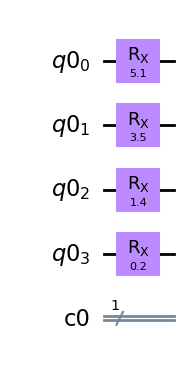

In [5]:
# feature map test
qc,c = feature_map(X[0], 'rx')
qc.draw('mpl')

# Using entanglment and parameteristaion

In [6]:
def variational_circuit(qc, theta, rotation_type):
    
    for i in range(N-1):
        qc.cnot(i, i+1)
    qc.cnot(N-1, 0)
    
    if rotation_type == 'rx':
        for i in range(N):
            qc.rx(theta[i], i)
    elif rotation_type == 'ry':
        for i in range(N):
            qc.ry(theta[i], i)
    elif rotation_type == 'rz':
        for i in range(N):
            qc.rz(theta[i], i)
            
    return qc

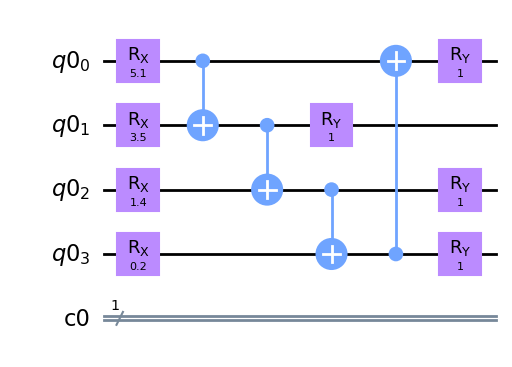

In [7]:
qc = variational_circuit(qc, np.ones(4), 'ry')
qc.draw('mpl')

# Defining the algorithm

In [8]:
def quantum_nn(X, theta, shots, encoding_type, rotation_type, simulator=True):
    
    qc, c = feature_map(X, encoding_type)
    qc = variational_circuit(qc, theta, rotation_type)
    qc.measure(0, c)

    backend = Aer.get_backend('qasm_simulator')
    
    if simulator == False:
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibm_oslo')
        
    job = qiskit.execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    return counts['1']/shots


In [9]:
qc, c = feature_map(X[0], 'rz')
qc = variational_circuit(qc, np.ones(4), 'rz')
qc.measure(0, c)
backend = Aer.get_backend('qasm_simulator')
    
job = qiskit.execute(qc, backend, shots=5000)
result = job.result()
counts = result.get_counts(qc)
print(counts)

{'0': 5000}


In [10]:
# quantum_nn test
quantum_nn(X[0], np.ones(4), 5000, 'rx', 'ry')

0.5374

# Defining the loss function

In [11]:
def loss(prediction, target):
    return(prediction-target)**2

In [12]:
# loss test
loss(quantum_nn(X[0], [0.9, 0.9, 0.9, 0.9], 5000, 'rx', 'ry'), Y[0])

0.29528356

# Defining the gradient function (gradient descent)

In [13]:
def gradient(X, Y, theta, delta, shots, encoding_type, rotation_type):

    grad = []
    for i in range(len(theta)):
        
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        prediction_1 = quantum_nn(X, dtheta, shots, encoding_type, rotation_type)
        prediction_2 = quantum_nn(X, theta, shots, encoding_type, rotation_type)
        
        grad.append((loss(prediction_1, Y) - loss(prediction_2, Y)) / delta)
        
    return np.array(grad)

In [14]:
gradient(X[0], Y[0], np.ones(4), 0.01, 5000, 'rx', 'ry')

array([-0.304304,  0.451836,  0.086912,  0.195588])

# Defining Accuracy function

In [15]:
def accuracy(X, Y, theta, shots, encoding_type, rotation_type):
    
    counter = 0
    for X_i, Y_i, in zip(X, Y):
        prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
        
        if prediction < 0.5 and Y_i == 0:
            counter += 1
        elif prediction >= 0.5 and Y_i == 1:
            counter += 1
            
    return counter/len(Y)

In [16]:
# Accuracy test
accuracy(X_test, Y_test, [-1.5, 1.2, 0.6, -0.2], 1000, 'rx', 'ry')

0.3333333333333333

In [17]:
def get_best_weight(accuracies, weights):
    return(weights[accuracies.index(max(accuracies))])

# Training

# Test 1

In [18]:

N = 4
def model(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, encoding_type, rotation_type, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []

    print('Epoch \t Loss \t Training Accuracy \t theta')

    for i in range(epochs):
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots, encoding_type, rotation_type)

            if loss(quantum_nn(X_i, new_theta, shots, encoding_type, rotation_type), Y_i) < loss(quantum_nn(X_i, theta, shots, encoding_type, rotation_type), Y_i):
                theta = new_theta

        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots, encoding_type, rotation_type))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
    
    if optimizing_weights==True:
        acc = accuracy(x_test, y_test, get_best_weight(acc_list, weights_list), shots, encoding_type=encoding_gate, rotation_type=rotation_gate)
        return acc, get_best_weight(acc_list, weights_list), theta, loss_list, acc_list, weights_list
    else:
        acc = accuracy(x_test, y_test, theta, shots, encoding_type=encoding_gate, rotation_type=rotation_gate)
        return acc, theta, loss_list, acc_list, weights_list

In [19]:
gates = ['rx', 'ry', 'rz']
results = {}
for encoding_gate in gates:
    for rotation_gate in gates:
        circuit_type = encoding_gate + '-' + rotation_gate
        if circuit_type != 'rz-rz':
            print(f'Circuit type : {circuit_type} -> encoding : {encoding_gate} rotation : {rotation_gate}')
            acc, theta, loss_list, acc_list, weights_history = model(X_train, Y_train, X_test, Y_test, learning_rate=0.05, epochs=10, theta=np.ones(N), shots=5000, encoding_type=encoding_gate, rotation_type=rotation_gate, delta=0.01)
            results.update({circuit_type: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
            print(f" {circuit_type} accuracy : {results.get(circuit_type).get('accuracy')}")

Circuit type : rx-rx -> encoding : rx rotation : rx
Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.277 	 0.149 	 [1.0375746 0.9654568 1.0686986 1.1937474] 	 1
1 	 0.278 	 0.254 	 [1.2581338 1.4020034 1.1914352 1.2546114] 	 2
2 	 0.253 	 0.806 	 [2.0280744 1.0494676 1.537884  1.2720448] 	 3
3 	 0.217 	 0.836 	 [2.3937322 1.8508614 1.3891532 0.9614874] 	 4
4 	 0.206 	 0.821 	 [3.106878  2.074232  1.5321236 0.9720682] 	 5
5 	 0.201 	 0.836 	 [2.77958   1.7768904 1.4168372 1.0129292] 	 6
6 	 0.203 	 0.821 	 [3.0591354 2.292135  1.3307368 0.6041946] 	 7
7 	 0.202 	 0.806 	 [3.1724456 2.1620916 1.512981  0.9031142] 	 8
8 	 0.201 	 0.881 	 [3.2405266 2.0409356 1.5928534 0.7160202] 	 9
9 	 0.202 	 0.821 	 [3.266191  1.899588  1.8886872 0.5882426] 	 10
 rx-rx accuracy : 0.696969696969697
Circuit type : rx-ry -> encoding : rx rotation : ry
Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.269 	 0.866 	 [1.7119856 1.063855  0.88484   0.6114294] 	 1
1 	 0.236 	 0.821 	 [2.143525  1.0215344 0.6034684 

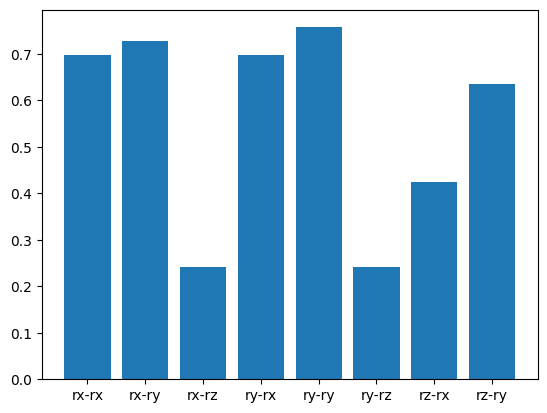

In [20]:
gates = ['rx', 'ry', 'rz']
labels = []
accuracies = []
for encoding_gate in gates:
    for rotation_gate in gates:
        circuit_type = encoding_gate + '-' + rotation_gate
        if circuit_type != 'rz-rz':
            labels.append(circuit_type)
            accuracies.append(results.get(circuit_type).get('accuracy'))
            
plt.bar(labels, accuracies)
plt.show()

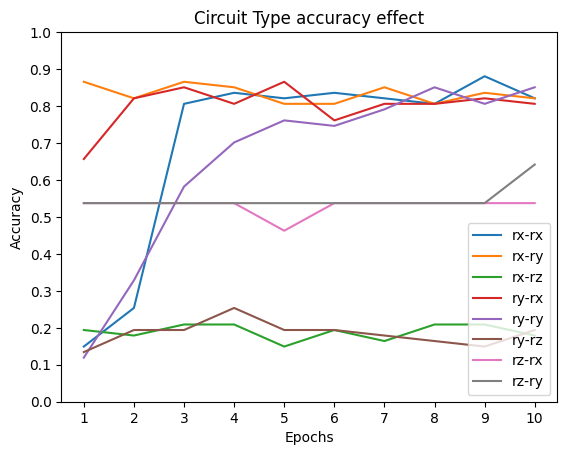

In [21]:
gates = ['rx', 'ry', 'rz']
labels = []
accuracies = []
for encoding_gate in gates:
    for rotation_gate in gates:
        circuit_type = encoding_gate + '-' + rotation_gate
        if circuit_type != 'rz-rz':
            plt.plot([x for x in range(1, 11)], results.get(circuit_type).get('acc_list'), label=circuit_type)
            
plt.xticks([x for x in range(1, 11)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Circuit Type accuracy effect')
plt.legend()
plt.show()

In [22]:

N = 4
def model_1(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, encoding_type, rotation_type, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []
    loss_val = 1
    i = 0
    print('Epoch \t Loss \t Training Accuracy \t theta')

    while loss_val > 0.17:
        
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots, encoding_type, rotation_type)

            if loss(quantum_nn(X_i, new_theta, shots, encoding_type, rotation_type), Y_i) < loss(quantum_nn(X_i, theta, shots, encoding_type, rotation_type), Y_i):
                theta = new_theta
        loss_val = np.mean(loss_tmp)
        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots, encoding_type, rotation_type))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
        i = i + 1
    
    return theta, loss_list, acc_list, weights_list

In [23]:
theta_b, loss_list_b, acc_list_b, weights_history_b = model_1(X_train, Y_train, X_test, Y_test, learning_rate=0.05, epochs=20, theta=np.ones(N), shots=5000, encoding_type='ry', rotation_type='ry', delta=0.01)

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.38 	 0.119 	 [0.6943924 0.6697098 1.1296004 1.2136644] 	 1
1 	 0.306 	 0.552 	 [-0.709632   1.0436024  1.084352   1.0022404] 	 2
2 	 0.218 	 0.731 	 [-1.411962   0.891719   1.077238   1.1745962] 	 3
3 	 0.194 	 0.687 	 [-1.2077172  0.9103718  1.360973   1.3192786] 	 4
4 	 0.196 	 0.761 	 [-1.4658838  0.8158928  1.4950458  1.278455 ] 	 5
5 	 0.183 	 0.776 	 [-1.7969448  0.8721948  1.9108124  1.320001 ] 	 6
6 	 0.172 	 0.821 	 [-2.029645   1.1043946  1.5843476  1.323159 ] 	 7
7 	 0.17 	 0.851 	 [-2.1154078  0.6423552  1.6284772  1.4521664] 	 8


In [24]:

N = 4
def model_2(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, encoding_type, rotation_type, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []

    print('Epoch \t Loss \t Training Accuracy \t theta')

    for i in range(epochs):
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots, encoding_type, rotation_type)

            if loss(quantum_nn(X_i, new_theta, shots, encoding_type, rotation_type), Y_i) < loss(quantum_nn(X_i, theta, shots, encoding_type, rotation_type), Y_i):
                theta = new_theta

        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots, encoding_type, rotation_type))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
    
    return theta, loss_list, acc_list, weights_list

In [25]:
for learning_rate in [0.001, 0.01, 0.05, 0.1]:
    theta, loss_list, acc_list, weights_history = model_2(X_train, Y_train, X_test, Y_test, learning_rate=learning_rate, epochs=20, theta=np.ones(N), shots=5000, encoding_type='ry', rotation_type='ry', delta=0.01)
    acc = accuracy(X_test, Y_test, theta, 5000, encoding_type='ry', rotation_type='ry')
    results.update({learning_rate: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
    print(f" Learning rate : {learning_rate} accuracy : {results.get(learning_rate).get('accuracy')}")

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.382 	 0.134 	 [0.990084   0.98988537 0.99092212 1.00979716] 	 1
1 	 0.383 	 0.134 	 [1.00064423 0.9880045  0.99699791 1.00155621] 	 2
2 	 0.384 	 0.164 	 [1.00517304 0.98589493 0.99291202 1.0015056 ] 	 3
3 	 0.382 	 0.164 	 [1.02276146 0.97686055 0.98574417 0.9941869 ] 	 4
4 	 0.384 	 0.134 	 [1.02056014 0.97893357 0.99250857 0.9927042 ] 	 5
5 	 0.385 	 0.209 	 [1.03365336 0.97389511 1.0010542  0.99105453] 	 6
6 	 0.384 	 0.179 	 [1.0357082  0.97808198 0.98960044 0.98592551] 	 7
7 	 0.385 	 0.149 	 [1.03607334 0.97513128 0.9936596  0.97794125] 	 8
8 	 0.384 	 0.149 	 [1.02738864 0.97073866 1.00582908 0.97103871] 	 9
9 	 0.383 	 0.194 	 [1.0365075  0.97048303 1.01498321 0.96565816] 	 10
10 	 0.383 	 0.164 	 [1.03212677 0.97639756 1.01968251 0.96096156] 	 11
11 	 0.385 	 0.164 	 [1.03051228 0.9759409  1.00946586 0.96023275] 	 12
12 	 0.383 	 0.134 	 [1.03516428 0.96491768 1.009043   0.96820596] 	 13
13 	 0.384 	 0.179 	 [1.03967047 0.9683687

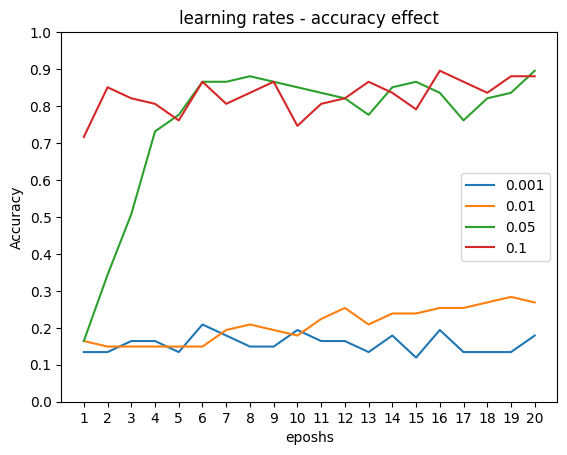

In [26]:
for learning_rate in [0.001, 0.01, 0.05, 0.1]:
    plt.plot([x for x in range(1, 21)], results.get(learning_rate).get('acc_list'), label=learning_rate)
            
plt.xticks([x for x in range(1, 21)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('eposhs')
plt.ylabel('Accuracy')
plt.title('learning rates - accuracy effect')
plt.legend()
plt.show()

In [27]:
n_shots_results = {}
for n_shots in [1000, 5000, 10000, 50000]:
    theta, loss_list, acc_list, weights_history = model_2(X_train, Y_train, X_test, Y_test, learning_rate=0.05, epochs=20, theta=np.ones(N), shots=n_shots, encoding_type='ry', rotation_type='ry', delta=0.01)
    acc = accuracy(X_test, Y_test, theta, n_shots, encoding_type='ry', rotation_type='ry')
    n_shots_results.update({n_shots: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
    print(f" Number of Shots : {n_shots} accuracy : {n_shots_results.get(n_shots).get('accuracy')}")

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.302 	 0.507 	 [-0.68424   0.605885  0.663185  0.74277 ] 	 1
1 	 0.21 	 0.776 	 [-1.508165  0.14184  -0.11494   0.37274 ] 	 2
2 	 0.174 	 0.821 	 [-2.65459   0.17087   0.95157   0.688595] 	 3
3 	 0.187 	 0.746 	 [-3.34067  1.78313  0.22867 -0.51064] 	 4
4 	 0.197 	 0.836 	 [-2.835165  1.50637   0.38465  -0.466615] 	 5
5 	 0.179 	 0.881 	 [-2.629265  2.201075  1.150105 -0.061845] 	 6
6 	 0.17 	 0.866 	 [-2.47919   2.71294  -0.402355 -0.30776 ] 	 7
7 	 0.168 	 0.836 	 [-2.57437   2.893795 -1.16564  -0.14078 ] 	 8
8 	 0.171 	 0.836 	 [-2.1987    2.376665 -1.3072   -0.807995] 	 9
9 	 0.184 	 0.806 	 [-3.10941   2.071005 -1.161985 -0.628185] 	 10
10 	 0.192 	 0.821 	 [-2.08415   3.721075 -2.054325  0.17274 ] 	 11
11 	 0.17 	 0.791 	 [-2.231365  3.61585  -2.422085  0.38201 ] 	 12
12 	 0.17 	 0.806 	 [-1.984275  4.084285 -2.198025  0.313605] 	 13
13 	 0.17 	 0.806 	 [-1.667805  4.553405 -2.77356   0.59701 ] 	 14
14 	 0.174 	 0.821 	 [-1.970165  4.

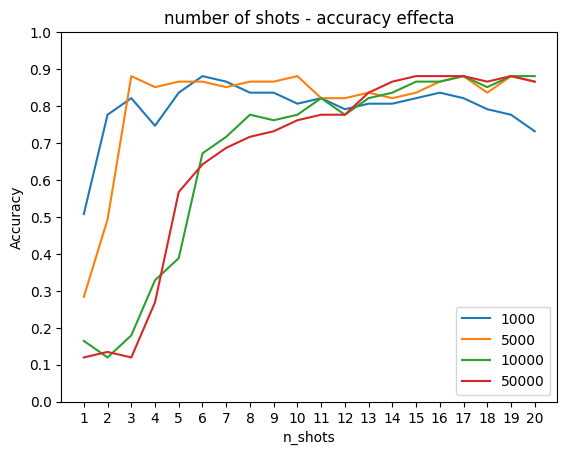

In [28]:
shots_list = [1000, 5000, 10000, 50000]
for n_shots in shots_list:
    plt.plot([x for x in range(1, 21)], n_shots_results.get(n_shots).get('acc_list'), label=n_shots)
            
plt.xticks([x for x in range(1, 21)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('n_shots')
plt.ylabel('Accuracy')
plt.title('number of shots - accuracy effecta')
plt.legend()
plt.show()

In [29]:
delta_results = {}
for delta in [0.01, 0.05, 0.1, 1]:
    theta, loss_list, acc_list, weights_history = model_2(X_train, Y_train, X_test, Y_test, learning_rate=0.1, epochs=20, theta=np.ones(N), shots=1000, encoding_type='ry', rotation_type='ry', delta=delta)
    acc = accuracy(X_test, Y_test, theta, 1000, encoding_type='ry', rotation_type='ry')
    delta_results.update({delta: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
    print(f" Delta : {delta} accuracy : {delta_results.get(delta).get('accuracy')}")

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.359 	 0.299 	 [-0.21343  1.77772  0.91916  1.01538] 	 1
1 	 0.2 	 0.821 	 [-2.04363  1.57363  6.06045 -0.81514] 	 2
2 	 0.169 	 0.851 	 [-1.98783  1.18928  4.15277  0.31151] 	 3
3 	 0.175 	 0.866 	 [-2.45263  0.47459  4.09515 -1.5619 ] 	 4
4 	 0.18 	 0.791 	 [-2.3659   0.75263  3.82767 -0.88406] 	 5
5 	 0.17 	 0.851 	 [-2.66617  0.22975  3.92408 -0.62466] 	 6
6 	 0.173 	 0.836 	 [-2.09255 -0.33724  2.79473 -1.3208 ] 	 7
7 	 0.175 	 0.866 	 [-2.07074 -1.95943  2.55827 -1.84432] 	 8
8 	 0.177 	 0.866 	 [-2.38519 -3.47517  3.51954 -0.24433] 	 9
9 	 0.171 	 0.791 	 [-2.04427 -3.63744  2.99248  0.80816] 	 10
10 	 0.169 	 0.866 	 [-2.69164 -3.38352  2.88911  0.7339 ] 	 11
11 	 0.18 	 0.851 	 [-2.86555 -5.85723  4.18872  0.75889] 	 12
12 	 0.189 	 0.806 	 [-2.57433 -6.54147  3.68616  1.19593] 	 13
13 	 0.173 	 0.881 	 [-2.3964  -5.03949  4.62919  1.2678 ] 	 14
14 	 0.174 	 0.851 	 [-2.69889 -7.12506  3.33762 -0.15152] 	 15
15 	 0.175 	 0.791 	 [-

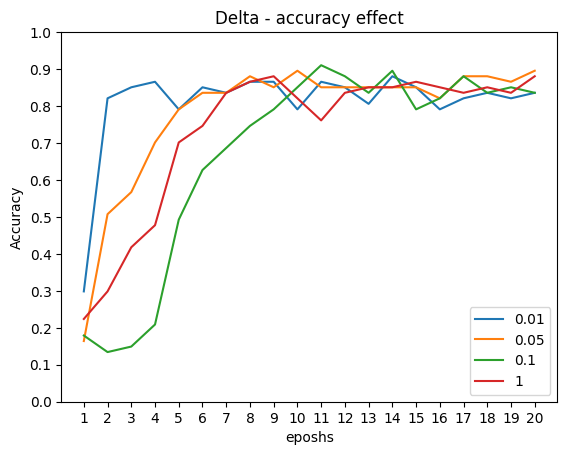

In [30]:
for delta in [0.01, 0.05, 0.1, 1]:
    plt.plot([x for x in range(1, 21)], delta_results.get(delta).get('acc_list'), label=delta)
            
plt.xticks([x for x in range(1, 21)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('eposhs')
plt.ylabel('Accuracy')
plt.title('Delta - accuracy effect')
plt.legend()
plt.show()

In [31]:
def feature_map_2(X, theta):
    n = 4

    qr = QuantumRegister(4)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(qr,c )
    for i, x in enumerate(X):
        qc.ry(x, i)
    for i in range(n-1):
        qc.cx(i, i+1)

    qc.barrier()
    for i in range(4):
        qc.rz(theta[i], i)
    qc.barrier()

    for i in reversed(range(n-1)):
        qc.cx(i, i+1)
    qc.h(0)

    return qc, c

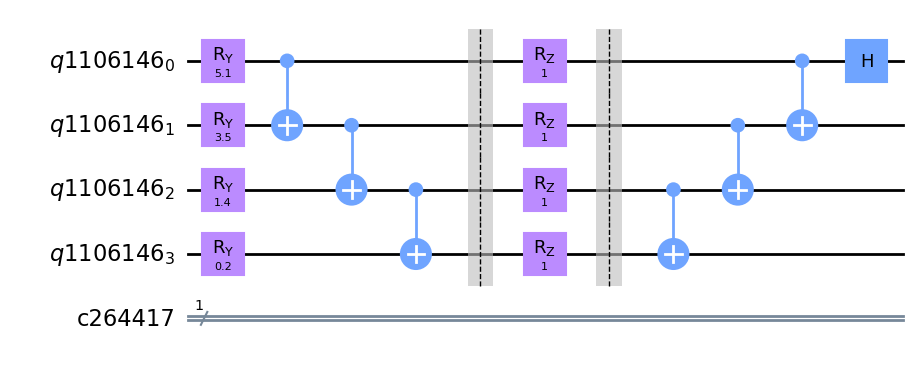

In [32]:
qc, c = feature_map_2(X[0], np.ones(4))
qc.draw('mpl')

In [33]:
def quantum_nn(X, theta, shots, encoding_type=None, rotation_type=None, simulator=True):
    
    qc, c = feature_map_2(X, theta)
    qc.measure(0, c)

    backend = Aer.get_backend('qasm_simulator')
    
    if simulator == False:
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibm_oslo')
        
    job = qiskit.execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    return counts['1']/shots

In [34]:
def accuracy(X, Y, theta, shots):
    
    counter = 0
    for X_i, Y_i, in zip(X, Y):
        prediction = quantum_nn(X_i, theta, shots)
        
        if prediction < 0.5 and Y_i == 0:
            counter += 1
        elif prediction >= 0.5 and Y_i == 1:
            counter += 1
            
    return counter/len(Y)

In [35]:
def gradient(X, Y, theta, delta, shots):

    grad = []
    for i in range(len(theta)):
        
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        prediction_1 = quantum_nn(X, dtheta, shots)
        prediction_2 = quantum_nn(X, theta, shots)
        
        grad.append((loss(prediction_1, Y) - loss(prediction_2, Y)) / delta)
        
    return np.array(grad)

In [36]:
N = 4
def model_5(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []

    print('Epoch \t Loss \t Training Accuracy \t theta')

    for i in range(epochs):
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots)

            if loss(quantum_nn(X_i, new_theta, shots), Y_i) < loss(quantum_nn(X_i, theta, shots), Y_i):
                theta = new_theta

        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
    
    return theta, loss_list, acc_list, weights_list

In [38]:
theta, loss_list, acc_list, weights_list = model_5(X_train, Y_train, X_test, Y_test, 0.01, 100, [1, 1, 1, 1], 5000, 0.01)

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.179 	 0.776 	 [1.0557328  1.11480332 1.02822288 1.06775408] 	 1
1 	 0.173 	 0.657 	 [1.11322456 1.03122936 1.10353572 1.06513432] 	 2
2 	 0.172 	 0.597 	 [1.107535   1.05864676 1.07241268 1.15051448] 	 3
3 	 0.17 	 0.672 	 [1.13449912 1.05323496 1.07568304 1.22769444] 	 4
4 	 0.17 	 0.642 	 [1.15724748 1.12344064 1.10426956 1.24764656] 	 5
5 	 0.17 	 0.612 	 [1.101333   1.0837384  1.12737736 1.2296674 ] 	 6
6 	 0.167 	 0.612 	 [1.14177828 1.15061108 1.13847232 1.18805756] 	 7
7 	 0.166 	 0.642 	 [1.1055412  1.18623604 1.11698096 1.17753832] 	 8
8 	 0.163 	 0.761 	 [1.1129732  1.34532148 1.0474402  1.11464704] 	 9
9 	 0.164 	 0.836 	 [1.07083128 1.38668036 1.08809404 1.14092024] 	 10
10 	 0.161 	 0.746 	 [1.01305084 1.38303652 1.10580452 1.1780808 ] 	 11
11 	 0.159 	 0.851 	 [1.0422214  1.346672   1.08638564 1.13435836] 	 12
12 	 0.162 	 0.806 	 [1.00146792 1.38454196 1.04384508 1.16877512] 	 13
13 	 0.161 	 0.836 	 [1.00018236 1.43030304 1

In [39]:
accuracy(X_test, Y_test, theta, 5000)

0.8484848484848485

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


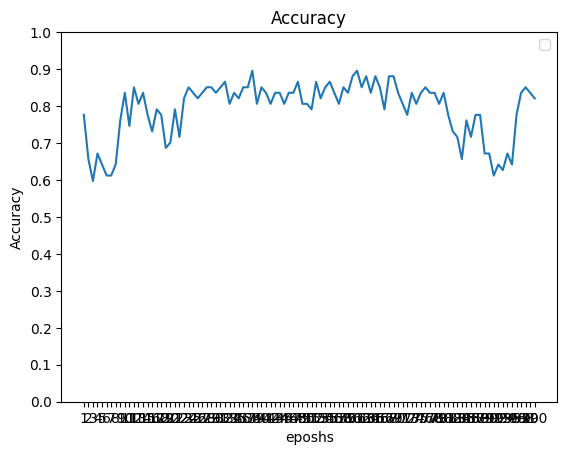

In [41]:
plt.plot([x for x in range(1, 101)], acc_list)
            
plt.xticks([x for x in range(1, 101)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('eposhs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

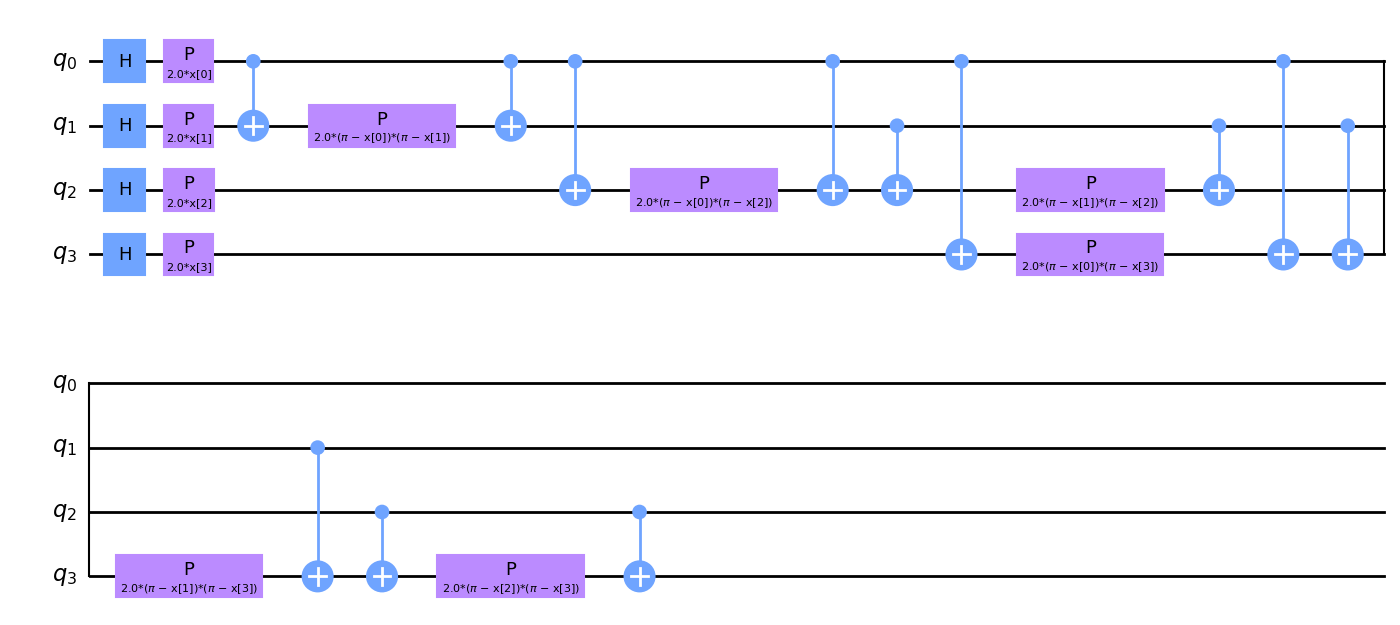

In [42]:
from qiskit.circuit.library import ZZFeatureMap

num_features = X_train.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

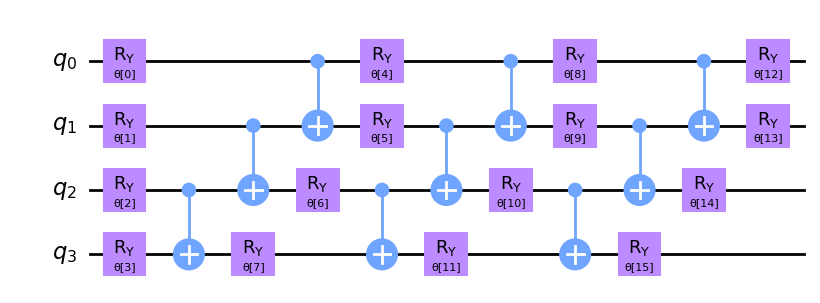

In [43]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

In [44]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [45]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [46]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
def acc_back(weights, accuracy):
    vqc_acc.append(vqc.score(X_train, Y_train))


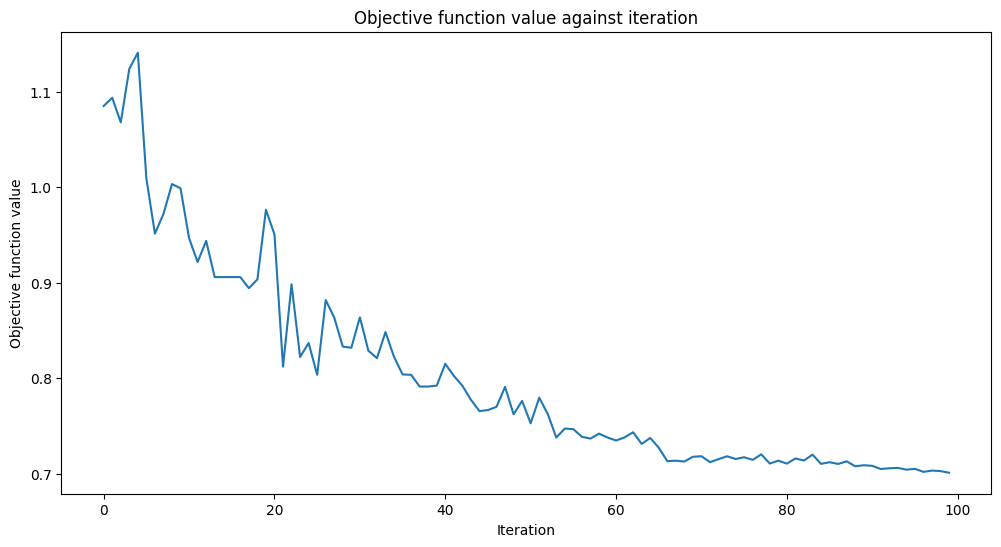

Training time: 82 seconds


In [47]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc_acc = []
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, Y_train)
vqc_acc.append(vqc.score(X_train, Y_train))
elapsed = time.time() - start


print(f"Training time: {round(elapsed)} seconds")

In [48]:
train_score_q4 = vqc.score(X_train, Y_train)
test_score_q4 = vqc.score(X_test, Y_test)


print(f"Quantum QNN on the training dataset: {accuracy(X_train, Y_train, theta, 5000):.2f}")
print(f"Quantum QNN on the test dataset:     {accuracy(X_test, Y_test, theta, 5000):.2f}")
print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum QNN on the training dataset: 0.85
Quantum QNN on the test dataset:     0.88
Quantum VQC on the training dataset: 0.82
Quantum VQC on the test dataset:     0.70


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


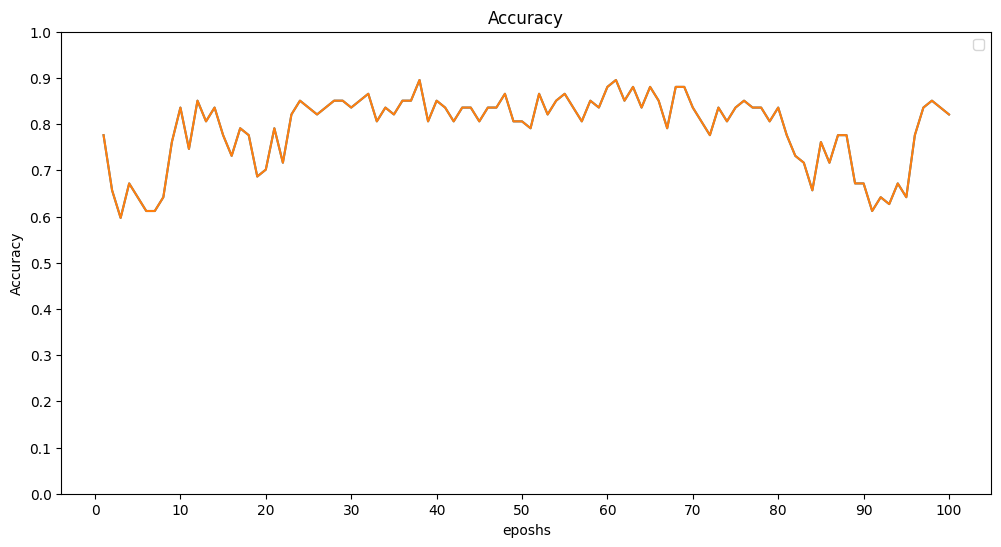

In [51]:
plt.plot([x for x in range(1, 101)], acc_list)
plt.plot([x for x in range(1, 101)], acc_list)
            
plt.xticks([x for x in range(0, 101, 10)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('eposhs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()